In [1]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import itertools
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/thesis/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Functions for data preparation and prediction

In [3]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = 'root_patches/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [4]:
def prepareData(df):
    data = []
    labels = []
    patches_path = 'root_patches/patches/'
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            feat, _ = np.histogram(im, bins = 100)
            data.append(feat)
            labels.append(df.loc[i, 'plastic'])
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [6]:
def get_preditictions(model, test_data, labels):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(labels, pred_class))
    return (pred_prob, pred_class)

In [ ]:
"""df = pd.read_csv('patch_info.csv')
_,_,df = prepareDataNN(df) # filter patches of size < 256 * 256

df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
df_unlab = df[df.plastic==-1].reset_index()

len(df_plastic), len(df_noplastic)"""

In [ ]:
"""df_labeled = pd.concat([df_plastic, df_noplastic], ignore_index=True)
partition = .85
test_set = df_labeled.copy()
print(len(test_set))
training_set = test_set.sample(frac=partition)
test_set = pd.merge(test_set, training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge'], axis=1)#.reset_index()
print(len(test_set))
validation_set = test_set.sample(frac=.5)
test_set = pd.merge(test_set, validation_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1)#.reset_index()
print(len(test_set))"""

1765
265
133


In [4]:
#training_set.to_csv('training_set.csv')
#test_set.to_csv('test_set.csv')
#validation_set.to_csv('validation_set.csv')
#df_unlab.to_csv('unlabeled.csv')

df_unlab = pd.read_csv('unlabeled.csv')
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
validation_set = pd.read_csv('validation_set.csv')

In [5]:
print(len(training_set[training_set['plastic']==0]), len(training_set[training_set['plastic']==1]) )
print(len(validation_set[validation_set['plastic']==0]), len(validation_set[validation_set['plastic']==1]) )
print(len(test_set[test_set['plastic']==0]), len(test_set[test_set['plastic']==1]) )

1079 681
94 61
99 56


# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
training_data_, training_labels_, _ = prepareData(training_set)
test_data_, test_labels_, _ = prepareData(test_set)

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_features=50)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(training_data_, training_labels_)
best_rfc = rf_random.best_estimator_
best_rfc.fit(training_data_, training_labels_)
pred_probs_rf = best_rfc.predict_proba(test_data_)[:, 1]

print(classification_report(test_labels_,  best_rfc.predict(test_data_)))

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91        99
         1.0       0.85      0.82      0.84        56

    accuracy                           0.88       155
   macro avg       0.88      0.87      0.87       155
weighted avg       0.88      0.88      0.88       155



In [ ]:
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       min_samples_split=5, n_estimators=73)

# CNN

In [59]:
# prepare data

training_data, training_labels, _ = prepareDataNN(training_set)
validation_data, validation_labels, _ = prepareDataNN(validation_set)
test_data, test_labels, _ = prepareDataNN(test_set)

### from scratch

In [9]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomTranslation(0.8, 0.5),
      layers.RandomFlip("vertical"),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.3),
    ]
)

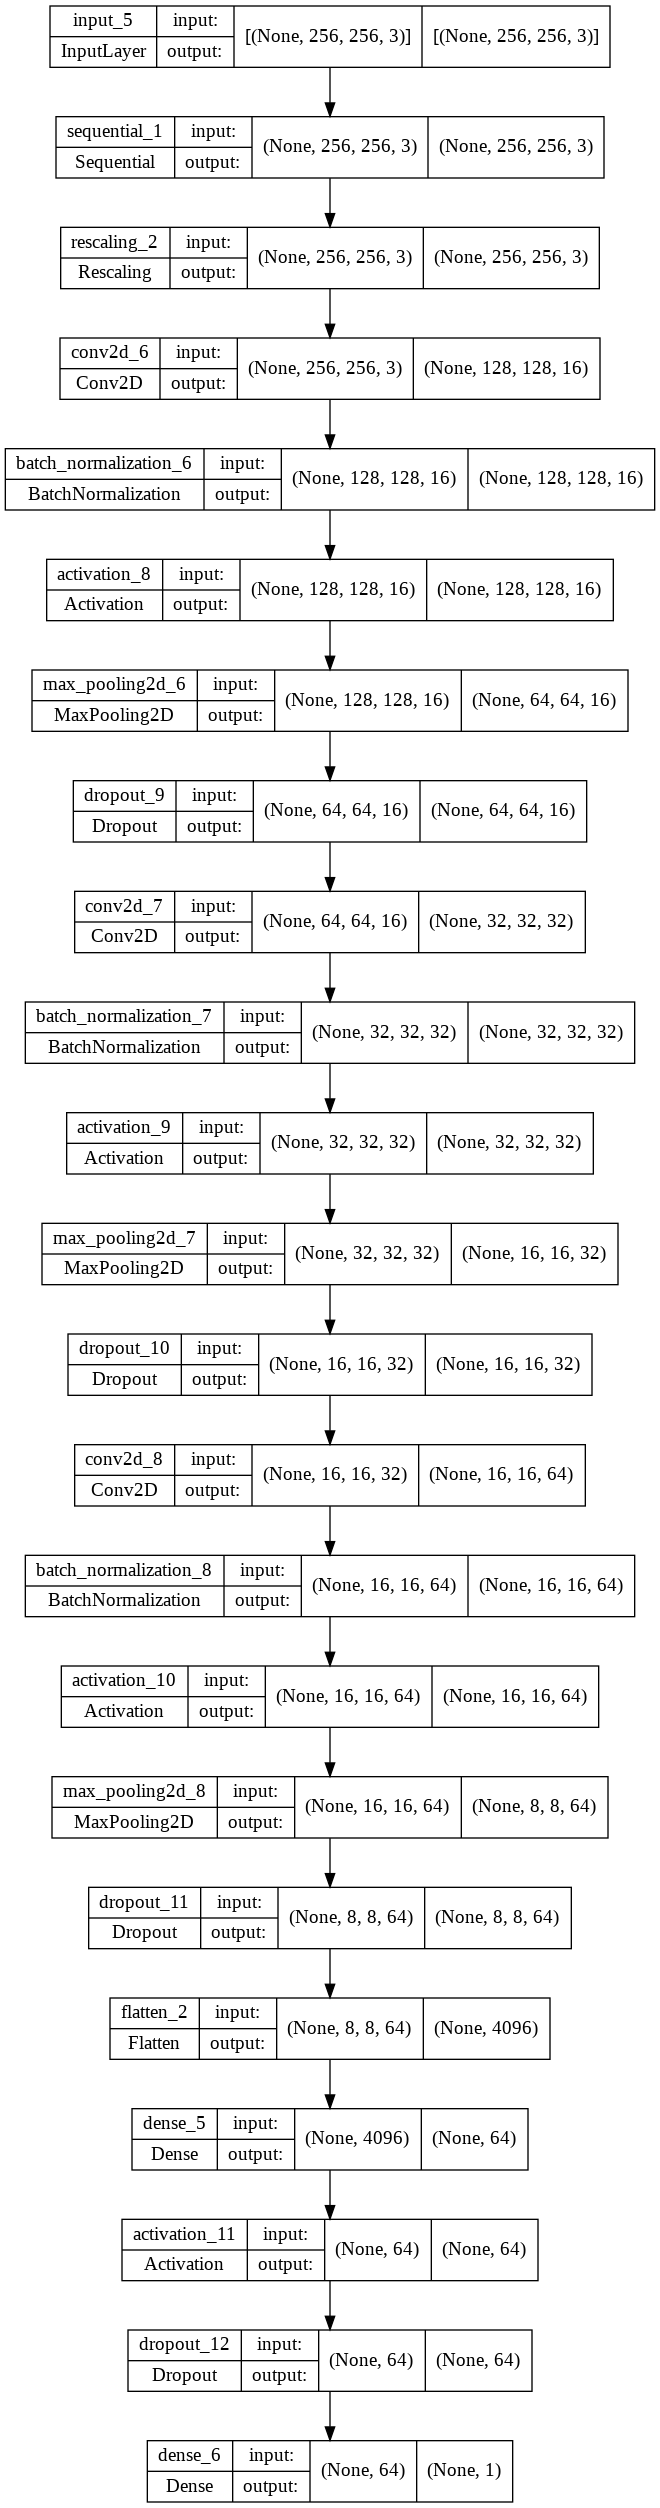

In [ ]:
def make_model(input_shape):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)

    #### added layers
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)
    ####

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)

    #x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    #x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.50)(x) # increased from .25

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3) 
model = make_model(input_shape=image_size)
keras.utils.plot_model(model, to_file='code/figures/CNN_new.png', show_shapes=True)

In [ ]:
X, Y = np.array(training_data + validation_data), np.array(training_labels + validation_labels)
X.shape, Y.shape 

In [ ]:
#train with kfold

from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
k = 1
epochs = 300

for train_ind, val_ind in kf.split(X):
  x_train,y_train = X[train_ind,:,:,:], Y[train_ind]
  x_val,y_val = X[val_ind,:,:,:], Y[val_ind]

  callbacks = [
      keras.callbacks.ModelCheckpoint("code/ckpts/cnn2_kf{}.h5".format(k), save_best_only=True, mode='min'),
      keras.callbacks.ReduceLROnPlateau(),
  ]
  tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                  histogram_freq=1, 
                  write_graph=True, 
                  write_images=False)
  
  model = make_model(input_shape=image_size)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  hist_cnn = model.fit(
      x=x_train, y=y_train , epochs=epochs, callbacks=[callbacks, tensorboard], batch_size=32, validation_data=(x_val, y_val))

  # save history 
  with open('code/ckpts/trainHistoryCNN2_kf{}'.format(k), 'wb') as file_pi:
      pickle.dump(hist_cnn.history, file_pi)
  k += 1

In [ ]:
hist_cnn1 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf1')
hist_cnn2 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf2')
hist_cnn3 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf3')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(np.mean([hist_cnn1['accuracy'], hist_cnn2['accuracy'], hist_cnn3['accuracy']], axis=0))
plt.plot(np.mean([hist_cnn1['val_accuracy'], hist_cnn2['val_accuracy'], hist_cnn3['val_accuracy']], axis=0))
plt.title('CNN average Accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(np.mean([hist_cnn1['loss'], hist_cnn2['loss'], hist_cnn3['loss']], axis=0))
plt.plot(np.mean([hist_cnn1['val_loss'], hist_cnn2['val_loss'], hist_cnn3['val_loss']], axis=0))
plt.title('CNN average Loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("code/figures/CNN_training_kf.png")

In [ ]:
model.load_weights("code/ckpts/cnn2_kf3.h5")
#model.load_weights("code/ckpts/new_cnn_51.h5")
#model.compile(
#    optimizer=keras.optimizers.Adam(1e-4),
#    loss="binary_crossentropy",
#    metrics=["accuracy"],
#)
pred_probs_cnn, pred_class_cnn = get_preditictions(model, test_data)

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90        99
         1.0       0.82      0.84      0.83        56

    accuracy                           0.88       155
   macro avg       0.87      0.87      0.87       155
weighted avg       0.88      0.88      0.88       155



In [ ]:
# assess performance on test 
# load kfold models
model1 = make_model(input_shape=image_size)
model1.load_weights("code/ckpts/cnn2_kf1.h5")

model2 = make_model(input_shape=image_size)
model2.load_weights("code/ckpts/cnn2_kf2.h5")

model3 = make_model(input_shape=image_size)
model3.load_weights("code/ckpts/cnn2_kf3.h5")

models = [model1, model2, model3]
merged_preds = np.zeros([len(test_labels),])
# majority voting 
for m in models:
  pred_probs_cnn, pred_class_cnn = get_preditictions(m, test_data)
  merged_preds += np.array(pred_class_cnn)

merged_preds = merged_preds // 2 # convert to classes

print(classification_report(test_labels,  merged_preds))

### CNN + Random Forest

In [ ]:
final_layer = "dense_5"#"global_average_pooling2d"
extractor = keras.Model(inputs=model.input,
                        outputs=model.get_layer(final_layer).output)
features = extractor(np.array(training_data))

rfcnn = RandomForestClassifier(n_estimators=100, max_features=50)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfcnn_random = RandomizedSearchCV(estimator = rfcnn, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1) #verbose=2, 
# Fit the random search model
rfcnn_random.fit(np.array(features), training_labels)

best_rfcnn = rfcnn_random.best_estimator_
best_rfcnn.fit(np.array(features), training_labels)

features_test = np.array(extractor(np.array(test_data)))
pred_probs_rfcnn = best_rfcnn.predict_proba(features_test)[:, 1]
accuracy_score(test_labels, best_rfcnn.predict(features_test))
print(classification_report(test_labels,  best_rfcnn.predict(features_test)))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94        99
         1.0       0.92      0.84      0.88        56

    accuracy                           0.92       155
   macro avg       0.92      0.90      0.91       155
weighted avg       0.92      0.92      0.92       155



In [ ]:
best_rfcnn

RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=31)

# MobNetV2

### Transfer Learning

In [45]:
# balance training classes according to number of litter patches=681
x_train = []
x_train_lab = []
count1 = 0
count2 = 0
for i in range(len(training_data)):
  if training_labels[i] == 0 and count1 <= 681:
    x_train.append(training_data[i])
    x_train_lab.append(0)
    count1 += 1
  elif training_labels[i] == 1 and count2 <= 681:
    x_train.append(training_data[i])
    x_train_lab.append(1)
    count2 += 1

In [77]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomContrast(0.1),
    ]
)

def make_mobilenetv2(training=True):
  if training:
    inputs = keras.Input(shape = (256, 256, 3))
    inputs = data_augmentation(inputs)

    # load pre-trained model and weights without last layer
    mobnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    mobnet.trainable = False
    x = mobnet(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # A Dense classifier with a single unit (binary classification)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    # final model to train
    tf_model_mobnet = keras.Model(inputs, outputs)
    
  else:
    inputs = keras.Input(shape = (256, 256, 3))
    x = data_augmentation(inputs)

    # load pre-trained model and weights without last layer
    x = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # A Dense classifier with a single unit (binary classification)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)    

    # final model
    tf_model_mobnet = keras.Model(inputs, outputs)
  return tf_model_mobnet

In [47]:
from  tensorflow.keras.applications import mobilenet_v2

#####################################################################################################
#Transfer Learning
#####################################################################################################
epochs_tl = 30
callbacks = [
    keras.callbacks.ModelCheckpoint("code/ckpts/warmup_mobnet/mobnetv2_{epoch}.h5", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
]

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

x_train = mobilenet_v2.preprocess_input(np.array(x_train))
x_val = mobilenet_v2.preprocess_input(np.array(validation_data))

tf_model_mobnet = make_mobilenetv2()
tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
    )

hist_mobnet1 = tf_model_mobnet.fit(
    x=x_train,
    y=np.array(x_train_lab),
    epochs=epochs_tl,
    callbacks=[callbacks, tensorboard],
    shuffle=False, batch_size=32,
    validation_data=(x_val, np.array(validation_labels))
)
# save history 
with open('code/ckpts/trainHistoryMobNetV2', 'wb') as file_pi:
    pickle.dump(hist_mobnet1.history, file_pi)

Epoch 1/30
43/43 [==============================] - 13s 222ms/step - loss: 0.5016 - binary_accuracy: 0.7483 - val_loss: 0.6897 - val_binary_accuracy: 0.6065 - lr: 0.0010
Epoch 2/30
43/43 [==============================] - 6s 136ms/step - loss: 0.4242 - binary_accuracy: 0.7916 - val_loss: 0.5509 - val_binary_accuracy: 0.7097 - lr: 0.0010
Epoch 3/30
43/43 [==============================] - 5s 115ms/step - loss: 0.3718 - binary_accuracy: 0.8254 - val_loss: 0.5114 - val_binary_accuracy: 0.7484 - lr: 0.0010
Epoch 4/30
43/43 [==============================] - 5s 114ms/step - loss: 0.3542 - binary_accuracy: 0.8371 - val_loss: 0.4872 - val_binary_accuracy: 0.7677 - lr: 0.0010
Epoch 5/30
43/43 [==============================] - 6s 142ms/step - loss: 0.3418 - binary_accuracy: 0.8459 - val_loss: 0.4675 - val_binary_accuracy: 0.7677 - lr: 0.0010
Epoch 6/30
43/43 [==============================] - 6s 150ms/step - loss: 0.3316 - binary_accuracy: 0.8555 - val_loss: 0.4510 - val_binary_accuracy: 0.787

In [49]:
####################################################################################################                
#Fine Tuning 
####################################################################################################

epochs_ft = 10

# Unfreeze the base model
tf_model_mobnet.trainable = True

callbacks = [
    keras.callbacks.ModelCheckpoint("code/ckpts/finetuning_mobnet/mobnetv2_{epoch}.h5", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
]

tf_model_mobnet.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

hist_mobnet2 = tf_model_mobnet.fit(
    x=x_train,
    y=np.array(x_train_lab), 
    epochs=epochs_ft, 
    callbacks=[callbacks, tensorboard], 
    shuffle=False, 
    batch_size=32, 
    validation_data=(x_val, np.array(validation_labels)),
    )
    
# save history 
with open('code/ckpts/trainHistoryMobNetV2_ft', 'wb') as file_pi:
    pickle.dump(hist_mobnet2.history, file_pi)

Epoch 1/10
43/43 [==============================] - 22s 402ms/step - loss: 0.1863 - binary_accuracy: 0.9244 - val_loss: 1.1085 - val_binary_accuracy: 0.6581 - lr: 1.0000e-05
Epoch 2/10
43/43 [==============================] - 16s 370ms/step - loss: 0.2028 - binary_accuracy: 0.9178 - val_loss: 0.8889 - val_binary_accuracy: 0.6774 - lr: 1.0000e-05
Epoch 3/10
43/43 [==============================] - 15s 353ms/step - loss: 0.1833 - binary_accuracy: 0.9230 - val_loss: 0.9217 - val_binary_accuracy: 0.6774 - lr: 1.0000e-05
Epoch 4/10
43/43 [==============================] - 16s 367ms/step - loss: 0.1990 - binary_accuracy: 0.9149 - val_loss: 0.6453 - val_binary_accuracy: 0.7742 - lr: 1.0000e-05
Epoch 5/10
43/43 [==============================] - 14s 333ms/step - loss: 0.1700 - binary_accuracy: 0.9325 - val_loss: 0.6707 - val_binary_accuracy: 0.7871 - lr: 1.0000e-05
Epoch 6/10
43/43 [==============================] - 15s 354ms/step - loss: 0.1511 - binary_accuracy: 0.9406 - val_loss: 0.5533 - v

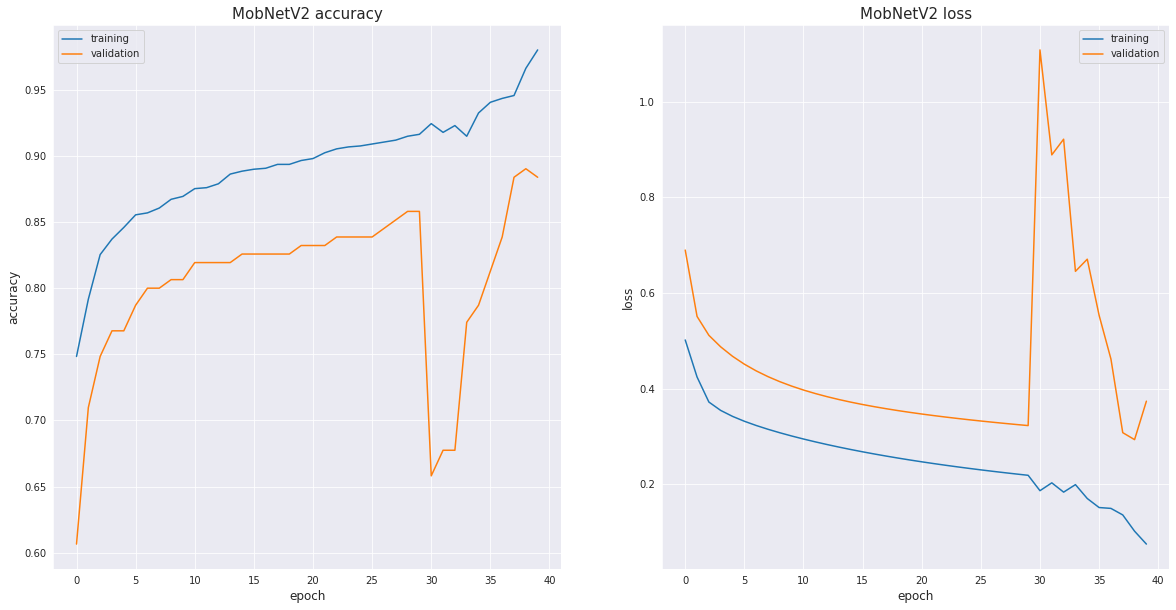

In [50]:
hist_mobnet1 = pd.read_pickle('code/ckpts/trainHistoryMobNetV2')
hist_mobnet2 = pd.read_pickle('code/ckpts/trainHistoryMobNetV2_ft')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_mobnet1['binary_accuracy'] + hist_mobnet2['binary_accuracy'])
plt.plot(hist_mobnet1['val_binary_accuracy'] + hist_mobnet2['val_binary_accuracy'])
plt.title('MobNetV2 accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_mobnet1['loss'] + hist_mobnet2['loss'])
plt.plot(hist_mobnet1['val_loss'] + hist_mobnet2['val_loss'])
plt.title('MobNetV2 loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("code/figures/MobNetV2_training.png")

In [78]:
tf_model_mobnet = make_mobilenetv2(training=False)
tf_model_mobnet.load_weights("code/ckpts/finetuning_mobnet/mobnetv2_9_balanced.h5")
#pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, training_data, training_labels)

In [79]:
test_data1 = mobilenet_v2.preprocess_input(np.array(test_data))
pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, test_data1, test_labels)

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86        99
         1.0       0.70      0.96      0.81        56

    accuracy                           0.84       155
   macro avg       0.84      0.87      0.84       155
weighted avg       0.88      0.84      0.84       155



### MobNetV2 + Random Forest

In [81]:
# extract features from last layer
final_layer = "global_average_pooling2d_24"
extractor_mobnet = keras.Model(inputs=tf_model_mobnet.input,
                        outputs=tf_model_mobnet.get_layer(final_layer).output)
features_mobnet = []
step = 300
for i in range(0, len(training_data), step):
    if i + step >= len(training_data):
        end = len(training_data)
    else: 
        end = i + step
    features_mobnet.append(np.array(extractor_mobnet(np.array(training_data[i:end]))))
features_mobnet = np.array(list(itertools.chain(*features_mobnet)))
features_mobnet_test = np.array(extractor_mobnet(np.array(test_data)))

# train random forest with mobnetfeatures 
rfmobnet = RandomForestClassifier(n_estimators=100, max_features=50) #

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfmobnet_random = RandomizedSearchCV(estimator = rfmobnet, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1) #verbose=2, 
# Fit the random search model
rfmobnet_random.fit(np.array(features_mobnet), training_labels)

best_rfmobnet = rfmobnet_random.best_estimator_
best_rfmobnet.fit(np.array(features_mobnet), training_labels)

pred_probs_rfmobnet = best_rfmobnet.predict_proba(features_mobnet_test)[:, 1]
accuracy_score(test_labels, best_rfmobnet.predict(features_mobnet_test))
print(classification_report(test_labels,  best_rfmobnet.predict(features_mobnet_test)))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87        99
         1.0       0.77      0.73      0.75        56

    accuracy                           0.83       155
   macro avg       0.81      0.81      0.81       155
weighted avg       0.82      0.83      0.82       155



In [82]:
best_rfmobnet

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_leaf=4, n_estimators=52)

# Semi-Supervised 


In [83]:
# unlabeled
X, Y, _ = prepareDataNN(df_unlab)

# merge labeled and unlabeled datasets
training_data_ss = training_data + X 
training_labels_ss = training_labels + Y

### CNN + Random Forest Semi-Supervised

In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
import itertools

#model = make_model(input_shape=image_size)
#model.load_weights("code/ckpts/cnn2_kf3.h5")

final_layer = "dense_12"
extractor = keras.Model(inputs=model.input,
                        outputs=model.get_layer(final_layer).output)
features_cnn = []
step = 300
for i in range(0, len(training_data_ss), step):
    if i + step >= len(training_data_ss):
        end = len(training_data_ss)
    else: 
        end = i + step
    features_cnn.append(np.array(extractor(np.array(training_data_ss[i:end]))))
features_cnn = np.array(list(itertools.chain(*features_cnn)))

In [ ]:
features_test_cnn = np.array(extractor(np.array(test_data)))
self_training_model_cnn = SelfTrainingClassifier(base_estimator=best_rfcnn)
self_training_model_cnn.fit(features_cnn, training_labels_ss)
print(classification_report(test_labels,  self_training_model_cnn.predict(features_test_cnn)))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92        99
         1.0       0.88      0.82      0.85        56

    accuracy                           0.90       155
   macro avg       0.89      0.88      0.89       155
weighted avg       0.90      0.90      0.90       155



In [ ]:
pred_probs_rfcnn_ss = self_training_model_cnn.predict_proba(features_test)[:, 1]

### MobileNetv2 + Random Forest Semi-Supervised

In [84]:
from sklearn.semi_supervised import SelfTrainingClassifier
import itertools

final_layer = "global_average_pooling2d_24"
extractor_mobnet = keras.Model(inputs=tf_model_mobnet.input,
                        outputs=tf_model_mobnet.get_layer(final_layer).output)
features_mobnet = []
step = 300
for i in range(0, len(training_data_ss), step):
    if i + step >= len(training_data_ss):
        end = len(training_data_ss)
    else: 
        end = i + step
    features_mobnet.append(np.array(extractor_mobnet(np.array(training_data_ss[i:end]))))
features_mobnet = np.array(list(itertools.chain(*features_mobnet)))

In [85]:
features_test_mobnet = np.array(extractor_mobnet(np.array(test_data)))
self_training_model = SelfTrainingClassifier(base_estimator=best_rfmobnet)
self_training_model.fit(features_mobnet, training_labels_ss)
print(classification_report(test_labels,  self_training_model.predict(features_test_mobnet)))
pred_probs_rfmobnet_ss = self_training_model.predict_proba(features_test_mobnet)[:, 1]

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.86        99
         1.0       0.73      0.79      0.76        56

    accuracy                           0.82       155
   macro avg       0.80      0.81      0.81       155
weighted avg       0.82      0.82      0.82       155



# Save Results

In [ ]:
predictions = pd.DataFrame(data={'test_labels': test_labels,
                                 'pred_prob_rf': pred_probs_rf,
                                 'pred_probs_cnnkf': list(itertools.chain(*pred_probs_cnn)),
                                 'pred_probs_mobnet': list(itertools.chain(*pred_probs_mobnet)),
                                 'pred_probs_rfcnnkf3': pred_probs_rfcnn,
                                 'pred_probs_rfmobnet': pred_probs_rfmobnet,
                                 'pred_probs_rfcnnkf3_ss': pred_probs_rfcnn_ss,
                                 'pred_probs_rfmobnet_ss': pred_probs_rfmobnet_ss})
#predictions.to_csv('predicitons.csv', index=False)

In [ ]:
predictions

,test_labels,pred_prob_rf,pred_probs_cnnkf,pred_probs_mobnet,pred_probs_rfcnnkf3,pred_probs_rfmobnet,pred_probs_rfcnnkf3_ss,pred_probs_rfmobnet_ss
0,1.0,0.992108,0.898236,0.021358,0.957447,0.804863,1.000000,0.894708
1,1.0,0.865764,0.751920,0.024743,0.989362,0.470417,1.000000,0.560427
2,1.0,0.591910,0.733243,0.033790,0.723404,0.534268,0.893617,0.521617
3,1.0,0.713015,0.758956,0.015584,0.882979,0.508758,0.968085,0.827651
4,1.0,0.993814,0.919270,0.033324,0.989362,0.811181,1.000000,0.946968
...,...,...,...,...,...,...,...,...
150,0.0,0.092563,0.267617,0.015395,0.202128,0.423972,0.074468,0.496621
151,0.0,0.073778,0.039592,0.008445,0.021277,0.455655,0.000000,0.854849
152,0.0,0.041252,0.031606,0.034270,0.000000,0.098976,0.000000,0.027010
153,0.0,0.016292,0.028704,0.016678,0.000000,0.494508,0.000000,0.818202
